# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [36]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [92]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))
    
    for index, class_name in enumerate(labels):
        prior[class_name] += W[index]
    
    # prior is normalized by dividing each element in the vector by its length (L2 norm)
    prior /= np.linalg.norm(prior) #L2 norm
    
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)

def mlParams(X, labels, W=None):
    
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)
    else:
        #initialize weight vector
        W = np.zeros((Npts,1)) #column vector
        
    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))
    
    for jdx, classes in enumerate(classes):
        
        # where is analogous to MATLAB’s find,
        # --> output is a tuple with index for each class label and then type
        # since we just want the class label indexes, we select [0]
        idx = np.where(labels==classes)[0] 
        xlc = X[idx,:] # Get the x for the class labels. Vectors are rows.
        w = W[idx]
        
        #mu[jdx,:] = np.sum(xlc*w, axis = 0)/np.sum(w)
        mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
        d = np.square((xlc - mu[jdx,:]))*w
        d = d.sum(axis = 0) # axis = 0 means that we sum across columns (all x summed, all y summed)
        sigma[jdx,:] = (1/np.sum(w))*np.diag(d)

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points

def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))
    classes = np.unique(labels)
    
    for k in range(Nclasses):
    
        sigm_det = np.linalg.det(sigma[k,:])
        
        # cant divide 0 by anything so you first have to extract the sigma diag with np.diag 
        # obs: sigma_inv is not a matrix anymore but it is a row vector 
        
        sigma_inv = 1/np.diag(sigma[k,:])
        
        # partone: elementwise multiplication multiplication with * instead of doing matrix multiplication with np.dot
        # once we have made the elementwise multiplication multiplication we sum across the rows (axis 1)
        # print(np.sum(-0.5*(X-mu[k,:])*(sigma_inv)*(X-mu[k,:]), axis=1).shape) --> (200,)
        # print(np.dot((X-mu[k,:])*(sigma_inv),(X-mu[k,:]).T).shape) --> (200x200)
        # since we want logProb to be (Nclasses, Npts), each class should have logProb[k].shape --> (200,)
        # I think this is due to the fact that we are only interested in multiplying each datapoint (x_1,y_1) with itself (x_1,y_1).T and not with other datapoints (x_2,y_2).T 
        
        partone = -0.5*np.log(sigm_det)+np.sum(-0.5*(X-mu[k,:])*(sigma_inv)*(X-mu[k,:]), axis=1)
        parttwo = np.log(prior[k])

        logProb[k,:] = np.array(partone) + parttwo
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    
    h = np.argmax(logProb,axis=0)
    
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [93]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

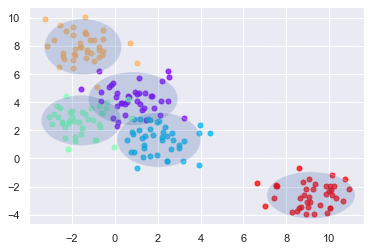

In [94]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)
prior = computePrior(labels)
#classifyBayes(X,prior,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [95]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [96]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

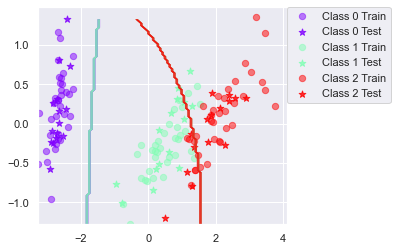

In [97]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

- **When can a feature independence assumption be reasonable and when not?**
    In general, it is not realistic to believe that features are independent. However, it may be a useful assumption in order to reduce complexity. It is not reasonable to made such an assumption when there is a high dependence between features (i.e. features "temperature: hot/cold" and "outlook: sunny/cloudy") OR when there is a high risk involved in a bad model (i.e. testing a drug to cure an illness).


- **How does the decision boundary look for the Iris dataset? How could one improve the classication results for this scenario by changing classifier or, alternatively, manipulating the data?**
    The classes are divided by two boundaries. The classes 0 and 1 are successfully divided. On the other hand, the classes 1 and 2 seem to not properly be divided (unintuitive curve). Alternative classifier: Support vector machine SVM (with slack).


## Boosting functions to implement

The lab descriptions state what each function should do.

In [98]:
wCur = np.ones((4,1))/float(4)

In [99]:
1-(vote == labels)

NameError: name 'vote' is not defined

In [100]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # wCur.reshape(-1) --> row vector
        error = np.dot(wCur.reshape(-1), (1-(vote == labels).astype(int)))
        alpha = 0.5*(np.log(1-error)-np.log(error))
        
        indexT = np.where(vote == labels)
        indexF = np.where(vote != labels)
        
        # weights are updated differently when the obs is == or != to the label
        wCur[indexT] = wCur[indexT] * np.exp(-alpha) 
        wCur[indexF] = wCur[indexF] * np.exp(alpha)
        
        wCur = wCur/np.sum(wCur) # normalisation is it same as /np.linalg.norm(wCur)??

        alphas.append(alpha) # you will need to append the new alpha
        
        # alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers) # Ncomps is the number of classifiers

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        for index, classifier in enumerate(classifiers):
            classified = classifier.classify(X)
            for i in range(Npts):
                votes[i][classified[i]] += alphas[index]
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [101]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [102]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/Users/alicedeschutter/.pyenv/versions/3.9.6/envs/kth/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rg

Trial: 0 Accuracy 33.3
Trial: 10 Accuracy 33.3
Trial: 20 Accuracy 33.3


/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/Users/alicedeschutter/.pyenv/versions/3.9.6/envs/kth/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rg

Trial: 30 Accuracy 33.3
Trial: 40 Accuracy 33.3
Trial: 50 Accuracy 33.3


/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/Users/alicedeschutter/.pyenv/versions/3.9.6/envs/kth/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rg

Trial: 60 Accuracy 33.3
Trial: 70 Accuracy 33.3


/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/Users/alicedeschutter/.pyenv/versions/3.9.6/envs/kth/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rg

Trial: 80 Accuracy 33.3
Trial: 90 Accuracy 33.3
Final mean classification accuracy  33.3 with standard deviation 0


/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/Users/alicedeschutter/.pyenv/versions/3.9.6/envs/kth/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rg

In [103]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)


Trial: 0 Accuracy 9.09
Trial: 10 Accuracy 9.09
Trial: 20 Accuracy 9.09
Trial: 30 Accuracy 9.09
Trial: 40 Accuracy 9.09
Trial: 50 Accuracy 9.09
Trial: 60 Accuracy 9.09
Trial: 70 Accuracy 9.09
Trial: 80 Accuracy 9.09
Trial: 90 Accuracy 9.09
Final mean classification accuracy  9.09 with standard deviation 1.78e-15


/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:58: RuntimeWarning: invalid value encountered in true_divide
  mu[jdx, :] = np.dot(np.transpose(w), xlc)/np.sum(w)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/var/folders/7k/f9wxkl8x1bd5dsmtfbng0rgh0000gn/T/ipykernel_41362/3554580713.py:61: RuntimeWarning: invalid value encountered in multiply
  sigma[jdx,:] = (1/np.sum(w))*np.diag(d)
/Users/alicedeschutter/.pyenv/versions/3.9.6/envs/kth/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/alicedeschutter/Documents/Projects/DD2421/lab3/labfuns.py:250: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_ar

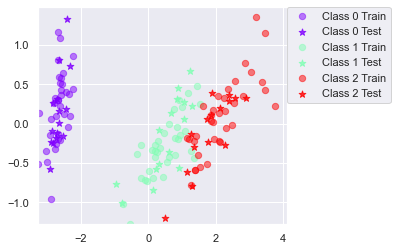

In [104]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [105]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [106]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [107]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 86.4
Trial: 10 Accuracy 89
Trial: 20 Accuracy 87.7
Trial: 30 Accuracy 93.5
Trial: 40 Accuracy 84.4
Trial: 50 Accuracy 79.9
Trial: 60 Accuracy 88.3
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 88.3
Trial: 90 Accuracy 85.7


In [ ]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])